# Entanglement: gather and plot results

In [ ]:
# This code is part of qcircha.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

In [148]:
# Plotting libraries and setting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import seaborn as sns
cmap = sns.color_palette('deep', as_cmap=True)
from qplotting import Qplotter
from qplotting.utils import set_size_pt

# Useful libraries
import numpy as np
import json
from tqdm import tqdm
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Simulation experiment
from qcircha.utils import gather_data, list_data
from qcircha.circuit_selector import pick_circuit
from qcircha.experiments import compute_bond_entanglement

# Path of the simulation data
data_path = "./data/ent_scaling/"
list_data(path=data_path)

['2022-03-09_11-15-26_377',
 '2022-02-25_18-43-03_427',
 '2022-03-09_10-51-15_895',
 '2022-03-01_12-35-51_898',
 '2022-03-01_12-28-13_706',
 '2022-02-28_17-17-12_138',
 '2022-02-28_16-42-55_464',
 '2022-02-28_17-58-55_935',
 '2022-03-01_17-04-41_29',
 '2022-02-28_17-05-58_812',
 '2022-02-28_17-02-58_278',
 '2022-02-26_18-47-34_697',
 '2022-02-28_14-34-11_580',
 '2022-02-26_19-30-20_890',
 '2022-03-09_10-52-33_310',
 '2022-03-01_16-53-11_400',
 '2022-02-26_19-23-34_315',
 '2022-02-25_18-22-50_651',
 '2022-02-28_18-07-59_681',
 '2022-03-10_14-19-44_213',
 '2022-02-28_14-29-13_329',
 '2022-02-28_14-22-37_117',
 '2022-03-01_12-50-54_684',
 '2022-02-28_17-50-17_956',
 '2022-03-01_18-29-41_431',
 '2022-02-28_16-44-58_330',
 '2022-03-10_14-20-39_713',
 '2022-02-25_18-05-23_651',
 '2022-03-09_10-54-08_19',
 '2022-02-28_18-01-34_505',
 '2022-03-09_11-12-57_552',
 '2022-02-26_19-25-46_58',
 '2022-02-28_17-45-16_517',
 '2022-02-26_18-45-40_923',
 '2022-02-26_18-43-39_545',
 '2022-02-28_17-40-06_2

## Entanglement scaling

##### 1) Single plot

Select a results from existing simulation run, given specifics of the QNN: _feature map_, _variational ansatz_, _entanglement topology_, ... . Inspect a `.json` file in the data folder to check available keys. 

In [149]:
# Provide keys in the json file, and corresponding desired value
data_runs = gather_data(key   = ['alternate', 'fmap'        , 'var_entanglement'],
                        value=[True,          'TwoLocal', 'linear'],
                        path=data_path)

# Select a run from those satisfying (key, values) requirements above
idx_run = 0
run = data_runs[idx_run]
print(f"{len(data_runs)} runs available. Selecting run: {run}")

# Load data
ent_data = np.load(data_path + run + ".npy", allow_pickle=True)
with open(data_path + run + '.json') as file:
    ent_metadata = json.load(file)
pp.pprint(ent_metadata)

2 runs available. Selecting run: 2022-02-28_16-42-55_464
{   'alternate': True,
    'backend': 'Aer',
    'fmap': 'TwoLocal',
    'fmap_entanglement': 'linear',
    'max_num_qubits': 12,
    'var_ansatz': 'TwoLocal',
    'var_entanglement': 'linear'}


A single element in the `ent_data` list, be it `data = ent_data[0]`, contains the results for a specific number of qubits, with varying repetitions. It is organized as follows:
1. `data[0]`: contains total entanglement (1d-array of dimension num_reps)
2. `data[1]`: standard deviation of total entanglement (not significant as results are consistent)
3. `data[3]`: expected total entanglement if Haar.

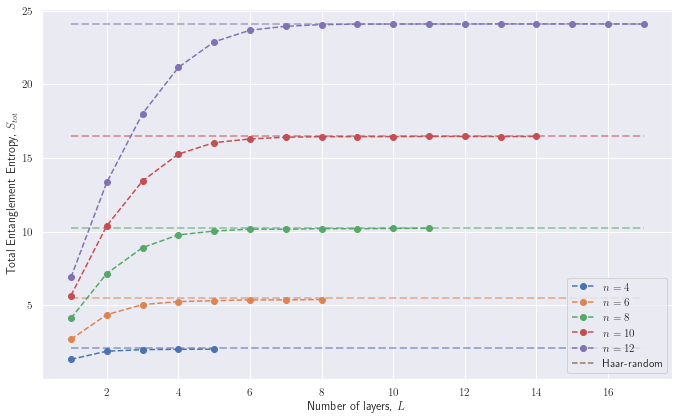

In [51]:
fig = plt.figure(figsize=(9.6, 6))

title = f"{ent_metadata['fmap']}_{ent_metadata['var_ansatz']}"
plt.ylabel("Total Entanglement Entropy, $S_{tot}$")
plt.xlabel("Number of layers, $L$")

plt.ylim(0, max(ent_data[-1, 0])+1)
plt.yticks(range(5, int(max(ent_data[-1, 0])+5), 5))

n_qubits = np.arange(4, ent_metadata['max_num_qubits']+1, 2, dtype=int)
for idx, data in enumerate(ent_data):
    plt.hlines(data[2], 1, len(ent_data[-1, 0]),
               ls="--", color=cmap[idx], lw=2, alpha=0.5)
    plt.plot(range(1, len(data[0])+1), data[0], ls="--",
             marker="o", c=cmap[idx], label=f"$n = {n_qubits[idx]}$")

plt.plot([], [], ls='--', color=cmap[idx+1], label="Haar-random")

plt.legend(loc=4)
plt.tight_layout()
#plt.savefig("data/Imgs/" + run + ".pdf", format="pdf")

##### 2) Entanglement map comparison: linear vs. circular vs. a2a

Selecting data

In [52]:
ent_datas = dict()
for ent_map in ['linear', 'circular', 'full']:
    data_runs = gather_data(key=['alternate', 'fmap'                 , 'var_ansatz', 'var_entanglement'],
                            value=[True     , 'TwoLocal_parametricRz', 'TwoLocal'  , ent_map], 
                            path=data_path)
    
    idx_run = 0
    run = data_runs[idx_run]
    print(f"{len(data_runs)} runs available. Selecting run: {run}")

    ent_datas[ent_map] = np.load(data_path + run + ".npy", allow_pickle=True)
    with open(data_path + run + '.json') as file:
        ent_metadata = json.load(file)
    pp.pprint(ent_metadata)

1 runs available. Selecting run: 2022-03-01_12-28-13_706
{   'alternate': True,
    'backend': 'Aer',
    'fmap': 'TwoLocal_parametricRz',
    'fmap_entanglement': 'linear',
    'max_num_qubits': 12,
    'var_ansatz': 'TwoLocal',
    'var_entanglement': 'linear'}
1 runs available. Selecting run: 2022-03-01_12-35-51_898
{   'alternate': True,
    'backend': 'Aer',
    'fmap': 'TwoLocal_parametricRz',
    'fmap_entanglement': 'circular',
    'max_num_qubits': 12,
    'var_ansatz': 'TwoLocal',
    'var_entanglement': 'circular'}
1 runs available. Selecting run: 2022-03-01_12-50-54_684
{   'alternate': True,
    'backend': 'Aer',
    'fmap': 'TwoLocal_parametricRz',
    'fmap_entanglement': 'full',
    'max_num_qubits': 12,
    'var_ansatz': 'TwoLocal',
    'var_entanglement': 'full'}


Plot data

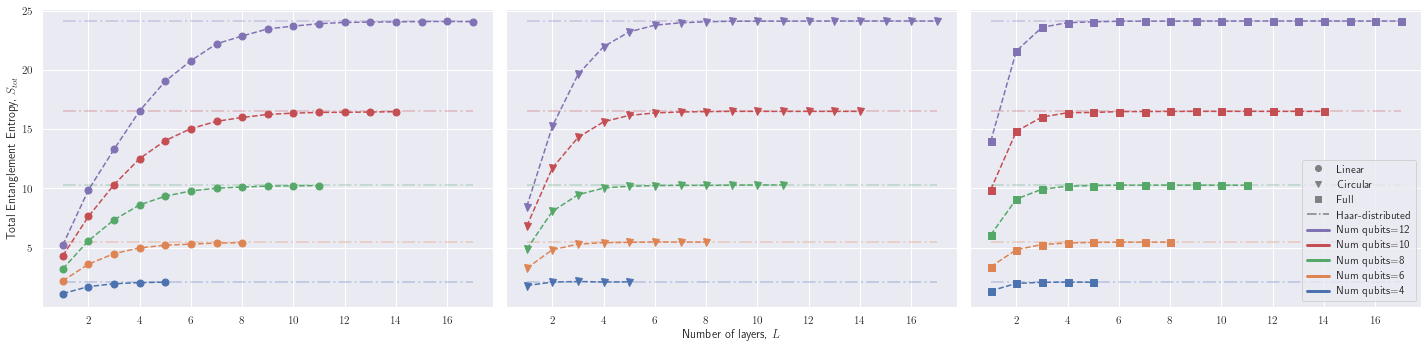

In [53]:
def do_plot(dataplot, ax=None):
    """Custom plot style"""
    # Run trough number of qubits
    for idx, data in enumerate(dataplot):
        # Haar limit
        ax.hlines(data[2], 1, len(_ent[-1, 0]), ls="-.", color=cmap[idx], lw=2, alpha=0.25)
        # Simulation results
        ax.errorbar(range(1, len(data[0])+1), data[0], yerr=0*data[1], ls="--", marker=markers[jdx], c=cmap[idx], markersize=7, alpha=1)
    return 


fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True, sharex=True)

title = f"{ent_metadata['fmap']}_{ent_metadata['var_ansatz']}"

# SET Y-AXIS
plt.ylim(0, max(ent_data[-1, 0])+1)
plt.yticks(range(5, int(max(ent_data[-1, 0])+5), 5))

n_qubits = np.arange(4, ent_metadata['max_num_qubits']+1, 2, dtype=int)
markers = ['o', 'v', 's']

# PLOT ENTANGLEMENT DATA
# Run through entanglement topology
for jdx, (ax, _ent) in enumerate(zip(axs, ent_datas.values())): 
    do_plot(_ent, ax = ax)

# MARKERS LEGEND
axs[2].plot([], [], ls=" ", marker=markers[0], c='gray', label="Linear")
axs[2].plot([], [], ls=" ", marker=markers[1], c='gray', label="Circular")
axs[2].plot([], [], ls=" ", marker=markers[2], c='gray', label="Full")

# LINE LEGEND
axs[2].plot([], [], ls='-.', color='grey', label="Haar-distributed")
for i in list(range(5))[::-1]:
    axs[2].plot([], [], lw=3, c=cmap[i], label=f"Num qubits={n_qubits[i]}")

# SET LABEL NAMES
axs[0].set_ylabel("Total Entanglement Entropy, $S_{tot}$")
axs[1].set_xlabel("Number of layers, $L$")

# PLOT LEGEND
axs[2].legend(loc=4)

plt.tight_layout()
#plt.savefig("data/Imgs/" + 'TwoLocalParam2q_TwoLocal' + ".pdf", format="pdf")


##### 3) Full comparison: architecture vs. entanglement (as in manuscript)

Selecting data

In [202]:
# SELECTING FIRST QNN ARCHITECTURE
ent_datas_QNN = dict()
for ent_map in ['linear', 'circular', 'full']:
    data_runs = gather_data(key=['alternate', 'fmap', 'var_ansatz', 'var_entanglement'],
                            value=[True, 'ZZFeatureMap', 'TwoLocal', ent_map],
                            path=data_path)

    idx_run = 0
    run = data_runs[idx_run]
    print(f"{len(data_runs)} runs available. Selecting run: {run}")

    ent_datas_QNN[ent_map] = np.load(data_path + run + ".npy", allow_pickle=True)
    with open(data_path + run + '.json') as file:
        ent_metadata = json.load(file)
    #pp.pprint(ent_metadata)

# SELECTING SECOND QNN ARCHITECTURE
print(" ")

ent_datas_QNN1 = dict()
for ent_map in ['linear', 'circular', 'full']:
    data_runs = gather_data(key=['alternate', 'fmap', 'var_ansatz', 'var_entanglement'],
                            value=[True, 'TwoLocal','TwoLocal', ent_map],
                            path=data_path)

    idx_run = 0
    run = data_runs[idx_run]
    print(f"{len(data_runs)} runs available. Selecting run: {run}")

    ent_datas_QNN1[ent_map] = np.load(data_path + run + ".npy", allow_pickle=True)
    with open(data_path + run + '.json') as file:
        ent_metadata = json.load(file)
    #pp.pprint(ent_metadata)

# SELECTING THIRD QNN ARCHITECTURE
print(" ")

ent_datas_QNN2 = dict()
for ent_map in ['linear', 'circular', 'full']:
    data_runs = gather_data(key=['alternate', 'fmap', 'var_ansatz', 'var_entanglement'],
                            value=[True, 'TwoLocal_parametricRz','TwoLocal', ent_map],
                            path=data_path)

    idx_run = 0
    run = data_runs[idx_run]
    print(f"{len(data_runs)} runs available. Selecting run: {run}")

    ent_datas_QNN2[ent_map] = np.load(data_path + run + ".npy", allow_pickle=True)
    with open(data_path + run + '.json') as file:
        ent_metadata = json.load(file)
    #pp.pprint(ent_metadata)

# SELECTING FOURTH QNN ARCHITECTURE
print(" ")

ent_datas_QNN3 = dict()
for ent_map in ['linear', 'circular', 'full']:
    data_runs = gather_data(key=['alternate', 'fmap', 'var_ansatz', 'var_entanglement'],
                            value=[True, 'circuit1', 'TwoLocal', ent_map],
                            path=data_path)

    idx_run = 0
    run = data_runs[idx_run]
    print(f"{len(data_runs)} runs available. Selecting run: {run}")

    ent_datas_QNN3[ent_map] = np.load(
        data_path + run + ".npy", allow_pickle=True)
    with open(data_path + run + '.json') as file:
        ent_metadata = json.load(file)
    #pp.pprint(ent_metadata)

data_to_plot = [ent_datas_QNN, ent_datas_QNN1, ent_datas_QNN2, ent_datas_QNN3]

2 runs available. Selecting run: 2022-02-25_18-43-03_427
2 runs available. Selecting run: 2022-02-28_17-05-58_812
2 runs available. Selecting run: 2022-02-28_17-17-12_138
 
2 runs available. Selecting run: 2022-02-28_16-42-55_464
2 runs available. Selecting run: 2022-02-28_16-44-58_330
2 runs available. Selecting run: 2022-02-26_19-30-20_890
 
1 runs available. Selecting run: 2022-03-01_12-28-13_706
1 runs available. Selecting run: 2022-03-01_12-35-51_898
1 runs available. Selecting run: 2022-03-01_12-50-54_684
 
2 runs available. Selecting run: 2022-03-09_10-51-15_895
2 runs available. Selecting run: 2022-03-09_10-52-33_310
2 runs available. Selecting run: 2022-03-09_10-54-08_19


In [203]:
architecture = ['a', 'b', 'c', 'd']
num_qubits = [4, 6, 8, 10, 12]

Fig dimension in pt: 468 385


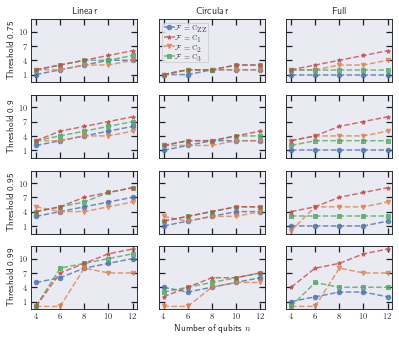

In [93]:
shape = { 'Linear' : 'v', 'Circular' : 'o', 'Full': 's'}
marker = ['o', 'v', 's', '*']
labels = ['$\\mathcal{F}=\\textsc{C}_{\\textsc{ZZ}}$', '$\\mathcal{F}=\\textsc{C}_{\\textsc{2}}$',
    '$\\mathcal{F}=\\textsc{C}_{\\textsc{3}}$', '$\\mathcal{F}=\\textsc{C}_{\\textsc{1}}$' ]


qplot = Qplotter()
qplot(nrows=4, ncols=3, figsize = set_size_pt(234*2, subplots=(4, 3)), sharey=True, sharex=True)

with qplot as qplt:
    # PLOT ENTANGLEMENT DATA
    new_data = [{}, {}, {}, {}]
    for th_idx, threshold in enumerate([0.75, 0.9, 0.95, 0.99]):
        for idx, ent_d in enumerate(data_to_plot): # Run through architectures
            for key, _ent in ent_d.items(): # Run through entanglement topology
                # Run through number of qubits
                new_data[idx][key] = []
                for jdx, single_ent in enumerate(_ent):
                    where = np.nonzero( single_ent[0]>threshold*single_ent[2] )[0]
                    if len(where) > 0:
                        where = where[0]
                    else:
                        where = -1

                    new_data[idx][key].append(where )
        for idx, architecture in enumerate(new_data):
            jdx = 0
            for key, value in architecture.items():
                qplt.ax[th_idx, jdx].plot(num_qubits, np.array(value)+1, marker[idx]+'--', color=cmap[idx], label=labels[idx],
                    alpha=0.8)
                qplt.ax[th_idx, jdx].tick_params(axis='y', which='major', left=True, right=True)
                qplt.ax[th_idx, jdx].tick_params(axis='x', which='major', bottom=True, top=True)
                qplt.ax[th_idx, jdx].tick_params(axis='y', which='minor', left=False, right=False)
                qplt.ax[th_idx, jdx].tick_params(axis='x', which='minor', bottom=False, top=False)
                qplt.ax[th_idx, jdx].set_xticks(num_qubits)
                qplt.ax[th_idx, jdx].set_yticks(np.arange(1, 11, 3))
                jdx += 1


        qplt.ax[th_idx, 0].set_ylabel(f'Threshold {threshold}')

    qplt.ax[0, 0].set_title(f'Linear')
    qplt.ax[0, 1].set_title(f'Circular')
    qplt.ax[0, 2].set_title(f'Full')

    qplt.ax[3, 1].set_xlabel("Number of qubits $n$")
    handles, labels = qplt.ax[0, 0].get_legend_handles_labels()
    # sort both labels and handles by labels
    sorter = [0, 3, 1, 2]
    labels = np.array(labels)[sorter]
    handles = np.array(handles)[sorter]
    qplt.ax[0, 1].legend(handles, labels, fontsize=7, loc="upper left")


    qplt.savefig(f'images/complete_comparison_zipped_BIG.pdf')

In [204]:
# PLOT ENTANGLEMENT DATA
new_data = [{}, {}, {}, {}]
threshold = 0.9
for idx, ent_d in enumerate(data_to_plot): # Run through architectures
    for key, _ent in ent_d.items(): # Run through entanglement topology
        # Run through number of qubits
        new_data[idx][key] = []
        for jdx, single_ent in enumerate(_ent):
            where = np.nonzero( single_ent[0]>threshold*single_ent[2] )[0]
            if len(where) > 0:
                where = where[0]
            else:
                where = -1

            new_data[idx][key].append(where )

Fig dimension in pt: 468 96


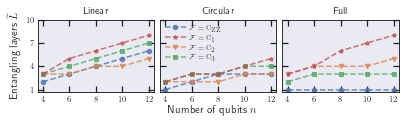

In [210]:
shape = { 'Linear' : 'v', 'Circular' : 'o', 'Full': 's'}
marker = ['o', 'v', 's', '*']
labels = ['$\\mathcal{F}=\\textsc{C}_{\\textsc{ZZ}}$', '$\\mathcal{F}=\\textsc{C}_{\\textsc{2}}$',
    '$\\mathcal{F}=\\textsc{C}_{\\textsc{3}}$', '$\\mathcal{F}=\\textsc{C}_{\\textsc{1}}$' ]


qplot = Qplotter()
qplot(nrows=1, ncols=3, figsize = set_size_pt(234*2, subplots=(1, 3)), sharey=True)

with qplot as qplt:
    for idx, architecture in enumerate(new_data):
        jdx = 0
        for key, value in architecture.items():
            qplt.ax[jdx].plot(num_qubits, np.array(value)+1, marker[idx]+'--', color=cmap[idx], label=labels[idx],
                alpha=0.8)
            qplt.ax[jdx].set_title( list(shape.keys())[jdx])
            qplt.ax[jdx].tick_params(axis='y', which='major', left=True, right=True)
            qplt.ax[jdx].tick_params(axis='x', which='major', bottom=True, top=True)
            qplt.ax[jdx].tick_params(axis='y', which='minor', left=False, right=False)
            qplt.ax[jdx].tick_params(axis='x', which='minor', bottom=False, top=False)
            qplt.ax[jdx].set_xticks(num_qubits)
            qplt.ax[jdx].set_yticks(np.arange(1, 11, 3))
            jdx += 1


    handles, labels = qplt.ax[1].get_legend_handles_labels()
    # sort both labels and handles by labels
    sorter = [0, 3, 1, 2]
    labels = np.array(labels)[sorter]
    handles = np.array(handles)[sorter]
    qplt.ax[1].legend(handles, labels, fontsize=7, loc="upper left",
        handletextpad=0.4, handlelength=3, ncol=1, frameon = False)
    qplt.supylabel('Entangling layers $\\widetilde{L}$', x=0.06)
    qplt.subplots_adjust(wspace=0.05)
    qplt.supxlabel("Number of qubits $n$", y=-0.12)

    qplt.savefig(f'images/complete_comparison_zipped_{threshold}.pdf')

Plot

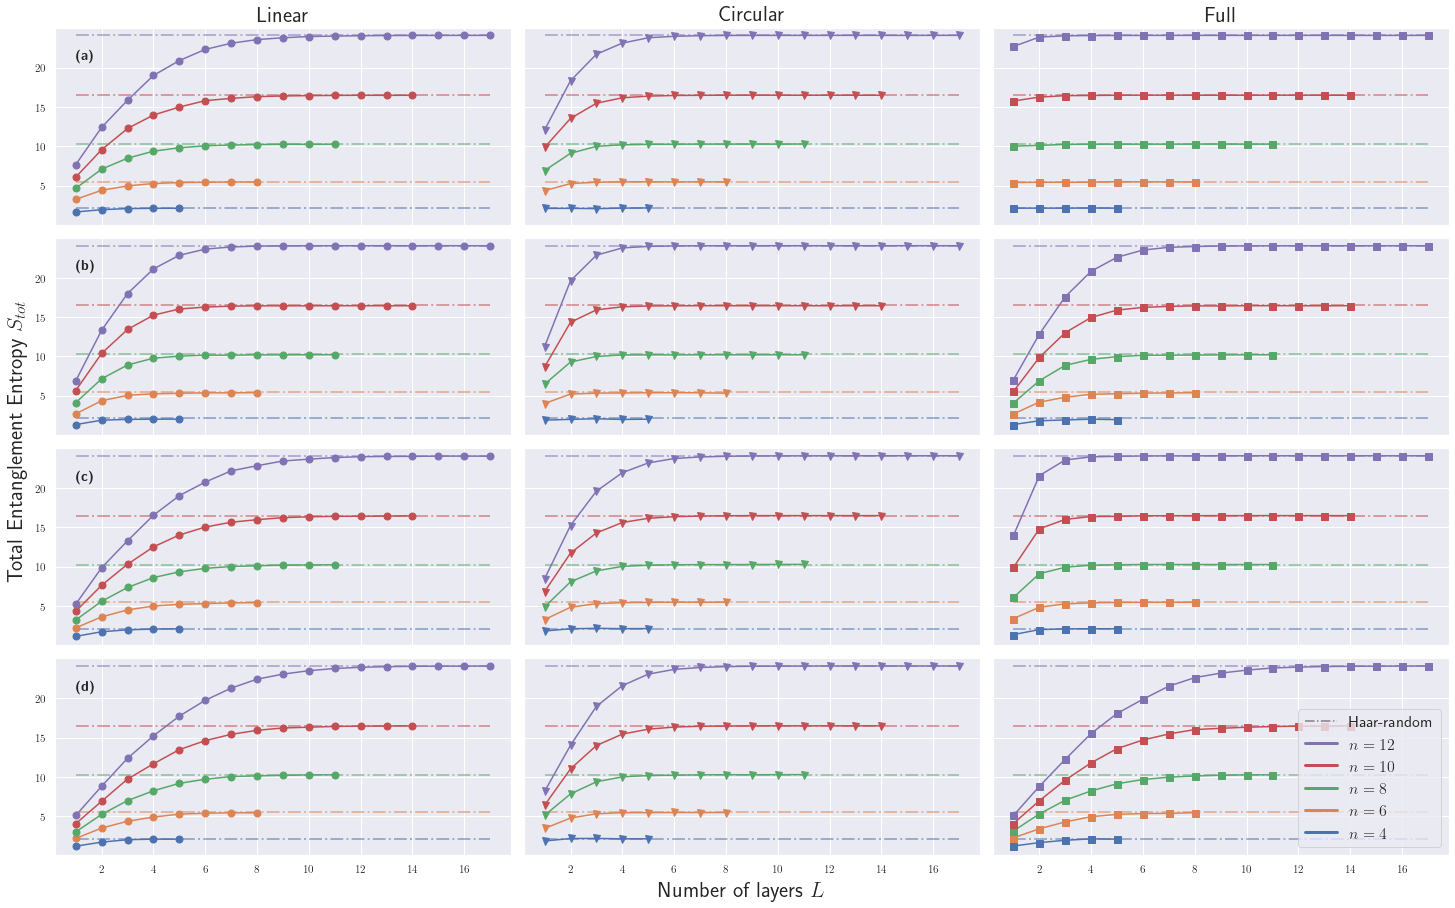

In [99]:
def do_plot(dataplot, ax=None):
    """Custom plot style"""
    # Run trough number of qubits
    alphas = np.ones(len(dataplot)) #np.linspace(0.4, 1, len(dataplot))
    for idx, data in enumerate(dataplot):
        # Haar limit
        ax.hlines(data[2], 1, len(_ent[-1, 0]), ls="-.", color=cmap[idx], lw=2, alpha=0.5)
        # Simulation results
        ax.errorbar(range(1, len(data[0])+1), data[0], yerr=0*data[1], alpha = alphas[idx], ls="-", marker=markers[jdx], c=cmap[idx], markersize=7)
    return

fig, axs = plt.subplots(len(data_to_plot), 3, figsize=(20, 12.42), sharey=True, sharex=True)

# SET Y-AXIS
plt.ylim(0, max(ent_datas_QNN['linear'][-1, 0])+1)
plt.yticks(range(5, int(max(ent_datas_QNN['linear'][-1, 0])+0), 5))

n_qubits = np.arange(4, ent_metadata['max_num_qubits']+1, 2, dtype=int)
markers = ['o', 'v', 's']

# PLOT ENTANGLEMENT DATA
for kdx, ent_d in enumerate(data_to_plot): # Run through architectures
    this_ax = axs[kdx]
    for jdx, (ax, _ent) in enumerate(zip(this_ax, ent_d.values())): # Run through entanglement topology
        do_plot(_ent, ax = ax)

# ADD PANEL LETTER
for idx, l in enumerate(['a','b','c','d','f'][:len(data_to_plot)]):
    axs[idx,0].text(1., 21., r"$\textbf{("+l+r")}$", fontsize = 14)

# ENTANGLING TOPOLOGY
axs[0, 0].set_title("Linear", fontsize=22)
axs[0, 1].set_title("Circular", fontsize=22)
axs[0, 2].set_title("Full", fontsize=22)

# LINE LEGEND
axs[-1, -1].plot([], [], ls='-.', color='grey', label="Haar-random")
for i in list(range(5))[::-1]:
    axs[-1, -1].plot([], [], lw=3, c=cmap[i], label=f"$n={n_qubits[i]}$")

# SET LABEL NAMES
fig.text(0.5, -0.01, 'Number of layers $L$', ha='center', fontsize=22)
fig.text(-0.01, 0.5, 'Total Entanglement Entropy $S_{tot}$', va='center', rotation='vertical', fontsize=22)

# PLOT LEGEND
axs[-1,-1].legend(loc=4, fontsize=16)

# PLOT LEGEND
#axs[-1,-1].legend(loc=4)\n",
# Shrink current axis's height by 10% on the bottom\n",
#handles, labels = axs[-1, -1].get_legend_handles_labels()
#handles, labels = handles[::-1], labels[::-1]
#handles[-1].set_lw(3)
#handles[-1].set_color('black')
#fig.legend(handles, labels, loc='lower center', fontsize=20, ncol=6, bbox_to_anchor=(0.5, 1.))
#
#left  = 0.06  # the left side of the subplots of the figure\n",
#right = 0.9   # the right side of the subplots of the figure\n",
#bottom = 0.13   # the bottom of the subplots of the figure\n",
#top = 0.9      # the top of the subplots of the figure\n",
#wspace = 0.1  # the amount of width reserved for blank space between subplots\n",
#hspace = 0.05   # the amount of height reserved for white space between subplots\n",
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

plt.tight_layout()
#plt.savefig('complete_comparison_final3' + ".pdf", format="pdf", bbox_inches="tight")


## Entanglement distribution across bonds

In [2]:
# Plotting libraries and setting
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
#matplotlib.rcParams['text.usetex'] = True

cmap = sns.color_palette(as_cmap=True)
sns.set_context("paper")

# Simulation experiment
from qcircha.experiments import compute_bond_entanglement

##### 1) Single architecture plot

Generating data

In [ ]:
# Quantum Cirucit structure
num_qubits = 8
alternate = True

# Choose simulation backend
#backend = 'MPS'
backend = 'Aer'

feature_map = 'Circuit1'
var_ansatz = 'TwoLocal'
ent_list, max_ent = compute_bond_entanglement(num_qubits,
                                              feature_map=feature_map, var_ansatz=var_ansatz,
                                              alternate=True, backend=backend,
                                              plot=False, max_bond_dim=None)

Plot data

In [ ]:
fig = plt.figure(figsize=(9.6, 6))

labels = [f'$e_{i}$' for i in range(num_qubits)]
plt.xticks(range(num_qubits), labels=labels)
plt.ylabel("Entanglement Entropy")
plt.xlabel("Bond index cut")

alphas = np.linspace(0.5, 1, len(ent_list[:num_qubits-1]))

for idx, data in enumerate(ent_list[:num_qubits-1]):
    plt.errorbar(range(1, num_qubits), data[0], yerr=0*data[1], color = cmap[idx], alpha = alphas[idx], label=f"$L={idx+1}$", marker='o')

plt.plot(range(1, num_qubits), max_ent, ls='--', color=cmap[-3], lw=2, alpha=1, marker='d', label="Maximally Entangled")
plt.plot(range(1, num_qubits), ent_list[0, 2], ls='-.', color=cmap[-2], lw=2, alpha=1, marker = 'v', label="Haar-random")

plt.legend(loc = 1)

plt.tight_layout()
#plt.savefig(f"data/Imgs/bond_plots/{feature_map}_{var_ansatz}_linear_2.pdf", format="pdf")

##### 2) Comparison of multiple structures (as in manuscript)

Generating data

In [122]:
%%capture

# Quantum Cirucit structure
num_qubits = 8
alternate = True

# Choose simulation backend
#backend = 'MPS'
backend = 'Aer'

feature_map = 'ZZFeatureMap'
var_ansatz = 'TwoLocal'
ent_list, max_ent = compute_bond_entanglement(num_qubits,
                                              feature_map=feature_map, var_ansatz=var_ansatz,
                                              alternate=True, backend=backend,
                                              plot=False, max_bond_dim=None)

print("Done! Doing second sctructure...")

feature_map1 = 'ZZFeatureMap_ring'
var_ansatz1 = 'TwoLocal_ring'
ent_list_c1, max_ent_c1 = compute_bond_entanglement(num_qubits,
                                                    feature_map=feature_map1, var_ansatz=var_ansatz1,
                                                    alternate=True, backend=backend,
                                                    plot=False, max_bond_dim=None)

print("Done! Doing third sctructure...")

feature_map2 = 'Circuit1'
var_ansatz2 = 'TwoLocal'
ent_list_c2, max_ent_c2 = compute_bond_entanglement(num_qubits,
                                                    feature_map=feature_map2, var_ansatz=var_ansatz2,
                                                    alternate=True, backend=backend,
                                                    plot=False, max_bond_dim=None)

# Data to be plotted
to_plot = [ent_list, ent_list_c1, ent_list_c2]

Plot data

Fig dimension in pt: 234 433


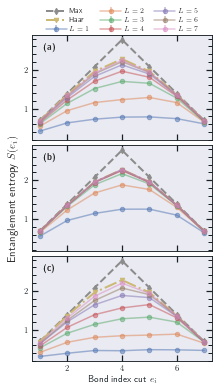

In [198]:
# Data to be plotted
to_plot = [ent_list, ent_list_c1, ent_list_c2]
alphas = np.repeat(0.5, 100)
def do_plot(dataplot, ax = None):
    for idx, data in enumerate(dataplot[:num_qubits-1]):
        ax.errorbar(range(1, num_qubits), data[0], yerr=0*data[1],
            color=cmap[idx], alpha=0.5, label=f"$L={idx+1}$", marker='o')
    ax.plot(range(1, num_qubits), max_ent, ls='--', color=cmap[-3], lw=2, alpha=1, marker='d', label="Max")
    ax.plot(range(1, num_qubits), ent_list[0, 2], ls='-.', color=cmap[-2], lw=2, alpha=1, marker='v', label="Haar")
    ax.tick_params(axis='y', which='both', left=True)
    ax.tick_params(axis='x', which='both', bottom=True)
    ax.tick_params(axis='x', which='minor', bottom=False, top=False)

qplot = Qplotter()
qplot(nrows=len(to_plot), ncols=1, figsize = set_size_pt(234, subplots=(3, 1)), sharex = True, sharey=True )
# Set axis names and labels
num_qubits=8
labels = [f'$e_{i}$' for i in range(num_qubits)]
#ax[0].set_xticks(range(num_qubits))
#ax[1].set_xticks(range(num_qubits))
#ax[2].set_xticks(range(num_qubits))
#ax[2].set_xticklabels(labels=labels, fontsize=14)
#ax[2].set_xlabel("Bond index cut $e_i$", fontsize=16)
#fig.supylabel("Entanglement entropy $S$", fontsize=16)

with qplot as qplt:
    qplt.ax[2].set_xlabel('Bond index cut $e_i$')
    qplt.supylabel('Entanglement entropy $S(e_i)$')

    # Define transparencies
    alphas = np.ones(len(ent_list[:num_qubits-1])) #np.linspace(0.4, 1, len(ent_list[:num_qubits-1]))

    # Plot data
    do_plot(to_plot[0], qplt.ax[0])
    do_plot(to_plot[1], qplt.ax[1])
    do_plot(to_plot[2], qplt.ax[2])

    # Add label to plot
    qplt.ax[0].text(1.1, 2.5, r"$\textbf{(a)}$")
    qplt.ax[1].text(1.1, 2.5, r"$\textbf{(b)}$")
    qplt.ax[2].text(1.1, 2.5, r"$\textbf{(c)}$")


    # Fix legend position
    #qplt.ax[1].legend(loc=1)
    handles, labels = qplt.ax[1].get_legend_handles_labels()
    # sort both labels and handles by labels
    qplt.ax[0].legend(handles, labels, fontsize=7,
        loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=3,
        handletextpad=0.4, handlelength=3, frameon = False)
    qplt.subplots_adjust(hspace=0.05)

    qplt.savefig("images/bond_entanglement.pdf")
    #plt.savefig(f"{feature_map}_{var_ansatz}_{feature_map1}_{var_ansatz1}_{feature_map2}_{var_ansatz2}_final.pdf", format="pdf", bbox_inches='tight')

## MPS Simulation

In [1]:
from qcircha.entanglement.haar_entanglement import haar_bond_entanglement
from qplotting import Qplotter
import numpy as np
import matplotlib.pyplot as plt

cmap = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), (0.5058823529411764, 0.4470588235294118, 0.7019607843137254), (0.5764705882352941, 0.47058823529411764, 0.3764705882352941), (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), (0.5490196078431373, 0.5490196078431373, 0.5490196078431373), (0.8, 0.7254901960784313, 0.4549019607843137), (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

Fig dimension in pt: 234 144


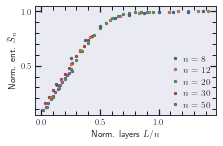

In [191]:
with Qplotter() as qplt:
    qplt.set_ylabel("Norm. ent. $\\widetilde{S}_n$")
    qplt.set_xlabel("Norm. layers $L/n$")
    qplt.tick_params(axis='y', which='both', left=True)
    qplt.tick_params(axis='x', which='both', bottom=True)
    num_qubs = [8, 12, 20, 30, 50]
    abbas = {nq:[np.loadtxt(f'data/marcos_plot/alternate_abbas{nq}.npy'), 0] for nq in num_qubs}

    abbas[30] = [np.mean([np.load(f'data/svd_checks/30/entanglement_{ii}.npy', allow_pickle=True) for ii in range(9)], axis=0),
                0]
    abbas[50] = [np.mean([np.load(f'data/svd_checks/50/entanglement_{ii}.npy', allow_pickle=True)for ii in range(10)], axis=0),
                0]


    alphas = np.ones(len(num_qubs))#np.linspace(0.2, 1, len(num_qubs))
    for idx, qub in enumerate(num_qubs[::-1]):
        data = abbas[qub][0]
        if qub < 30:
            num_reps = min(int( (len(data)-1 )/2 )+1, 20)
            reps = np.arange(1, num_reps)
        elif qub == 30:
            reps = np.arange(1, 14)
            num_reps = len(reps)+1
        elif qub == 40:
            continue
            reps = np.append(np.arange(1, 11), [12, 14])
            num_reps = len(reps)+1
        elif qub == 50:
            reps = np.arange(1, 14)
            num_reps = len(reps)+1
        else:
            num_reps = len(data)
            reps = np.arange(1, 11, 2)

        haar_ent = np.max( haar_bond_entanglement(qub) )

        yval = data[1:num_reps, :].max(axis=1)/haar_ent
        qplt.plot(reps/qub,  yval, ".", color=cmap[len(num_qubs)-idx-1], label=f"$n = {qub}$", alpha= alphas[idx])

    qplt.legend()
    handles, labels = qplt.get_legend_handles_labels()
    qplt.legend(handles[::-1], labels[::-1], frameon=False)

    qplt.savefig('images/entangling_speed.pdf')

## Alternate vs. Sequential data reuploading

In [100]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as pl

Fig dimension in pt: 234 144
Fig dimension in pt: 234 144


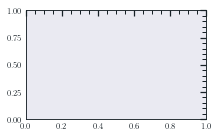

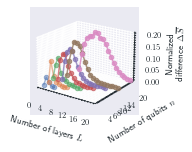

In [110]:
num_qubs = [4, 6, 8, 10, 12, 14, 20, 30, 40, 50]
abbas = {nq: [np.loadtxt(f'data/marcos_plot/alternate_abbas{nq}.npy'), np.loadtxt(f'data/marcos_plot/non_alternate_abbas{nq}.npy')] for nq in num_qubs}


qplot = Qplotter()
alphas = np.linspace(0.5, 1, len(num_qubs))

with qplot as qplt:
    qplot.fig = plt.figure(figsize=set_size_pt(234) )
    qplot.ax = pl.subplot(projection='3d')
    num_qubs = [4, 6, 8, 10, 12, 14, 20]
    for idx, nq in enumerate(num_qubs):

        haar = np.max(abbas[nq][0][0, :])
        alternate = abbas[nq][0][1:, nq//2]
        non_alternate = abbas[nq][1][1:, nq//2]
        fc = 1
        if nq != 20:
            fc = 2
        len_data = min(len(alternate)//fc, len(non_alternate)//fc)
        len_data = min(len_data, 20) # fixing plot

        xs = np.arange(1, len_data+1)

        y = [nq]*len(xs)

        alternate = alternate[:len_data]
        non_alternate = non_alternate[:len_data]
        normalization = (alternate + non_alternate)/2
        z = (alternate - non_alternate)/normalization

        qplt.ax.plot(xs, y, z, ls="-", marker="o", c=cmap[idx], label=f'Num qub={nq}', alpha = alphas[idx])

    qplt.ax.set_xlabel('Number of layers $L$')
    qplt.ax.set_zlabel('Normalized\n difference $\Delta \overline{S}$')
    qplt.ax.set_ylabel('Number of qubits $n$')

    qplt.ax.set_xlim(0, 20)
    qplt.ax.set_zlim(0, 0.2)

    qplt.ax.set_xticks(np.arange(0, 21, 4, dtype=int))
    qplt.ax.set_yticks(num_qubs)
    qplt.ax.set_zticks(np.linspace(0, 0.2, 5))

    # Set color to white (or whatever is "invisible")
    qplt.ax.xaxis.pane.set_edgecolor('w')
    qplt.ax.yaxis.pane.set_edgecolor('w')
    qplt.ax.zaxis.pane.set_edgecolor('w')

    # Grid color setup
    qplt.ax.xaxis._axinfo["grid"].update({"linewidth": 1, 'linestyle':'-', 'alpha':0.5, 'color':'w'})
    qplt.ax.yaxis._axinfo["grid"].update({"linewidth": 1, 'linestyle': '-', 'alpha': 0.5, 'color': 'w'})
    qplt.ax.zaxis._axinfo["grid"].update({"linewidth": 1, 'linestyle': '-', 'alpha': 0.5, 'color': 'w'})
    #ax.grid(False)

    # Pane color setup
    qplt.ax.xaxis.pane.set_color('#EAEAF2')
    qplt.ax.yaxis.pane.set_color('#EAEAF2')  # E6E6f2 # #EAEAF2
    qplt.ax.zaxis.pane.set_color('#EAEAF2')

    # Change view angle (standard is 30, -60)
    qplt.ax.view_init(20, -55)

    qplt.ax.tick_params(axis='y', which='minor', left=False, right=False)
    qplt.ax.tick_params(axis='x', which='minor', bottom=False, top=False)
    qplt.grid()

    qplt.savefig("images/entanglement_diff_3d_final.pdf")

Fig dimension in pt: 234 144


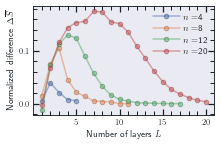

In [196]:
num_qubs = [4, 8, 12, 20]
abbas = {nq: [np.loadtxt(f'data/marcos_plot/alternate_abbas{nq}.npy'), np.loadtxt(f'data/marcos_plot/non_alternate_abbas{nq}.npy')] for nq in num_qubs}


qplot = Qplotter()
alphas = np.repeat(0.5, 10)

with qplot as qplt:
    for idx, nq in enumerate(num_qubs):

        haar = np.max(abbas[nq][0][0, :])
        alternate = abbas[nq][0][1:, nq//2]
        non_alternate = abbas[nq][1][1:, nq//2]
        fc = 1
        if nq != 20:
            fc = 2
        len_data = min(len(alternate)//fc, len(non_alternate)//fc)
        len_data = min(len_data, 20) # fixing plot

        xs = np.arange(1, len_data+1)

        y = [nq]*len(xs)

        alternate = alternate[:len_data]
        non_alternate = non_alternate[:len_data]
        normalization = (alternate + non_alternate)/2
        z = (alternate - non_alternate)/normalization

        qplt.plot(xs, z, ls="-", marker="o", color=cmap[idx], label="$n=$"+str(nq), alpha = alphas[idx])
        qplt.legend(handletextpad=0.4, handlelength=3, ncol=1, frameon = False)
        qplt.tick_params(axis='y', which='both', left=True)
        qplt.tick_params(axis='x', which='both', bottom=True)
        qplt.set_xlabel('Number of layers $L$')
        qplt.set_ylabel('Normalized difference $\Delta \overline{S}$')

        qplt.savefig("images/alternate_difference_2d.pdf")

## Difference between data reauploading, all random and real dataset

In [18]:
len_wine_dataset = 178*10
qub = 13
wine = np.array([np.load(f"data/datasets/wine/entanglement_{idx}.npy", allow_pickle=True) for idx in range(len_wine_dataset)] )
average_wine_over_dataset = wine.mean(axis=0)
std_wine_over_dataset = wine.std(axis=0)
max_wine_over_links = average_wine_over_dataset.max(axis=1)

rnd = np.array([np.load(f"data/all_random/entanglement_{idx}.npy", allow_pickle=True) for idx in range(2000)] )
average_rnd_over_dataset = rnd.mean(axis=0)
std_rnd_over_dataset = rnd.std(axis=0)
max_rnd_over_links = average_rnd_over_dataset.max(axis=1)

len_breast_dataset = 286*10
breast_cancer = np.array([np.load(f"data/datasets/breast_cancer/entanglement_{idx}.npy", allow_pickle=True) for idx in range(len_breast_dataset)] )
average_breast_over_dataset = breast_cancer.mean(axis=0)
std_breast_over_dataset = breast_cancer.std(axis=0)
max_breast_over_links = average_breast_over_dataset.max(axis=1)

data = np.loadtxt(f'data/marcos_plot/alternate_abbas{qub}.npy')
num_reps = min(int( (len(data)-1 )/2 )+1, 20)
reps = np.arange(1, num_reps)

Fig dimension in pt: 234 144


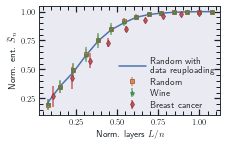

In [19]:
qub = 13
haar_ent = np.max( haar_bond_entanglement(qub) )
yval = data[1:num_reps, :].max(axis=1)/haar_ent
yval = yval[:14]
with Qplotter() as qplt:
    reps = np.arange(1, 15)
    qplt.set_ylabel("Norm. ent. $\\widetilde{S}_n$")
    qplt.set_xlabel("Norm. layers $L/n$")
    qplt.tick_params(axis='y', which='both', left=True)
    qplt.tick_params(axis='x', which='both', bottom=True)
    qplt.plot(reps/(qub),  yval, "-", color=cmap[0], label=f"Random with \n data reuploading")

    qplt.errorbar(reps/(qub),  max_rnd_over_links/haar_ent, std_rnd_over_dataset[:, 6]/haar_ent, color=cmap[1], label="Random", marker="s", ls="", markeredgecolor=np.array(cmap[1])*0.75, alpha=0.9)

    qplt.errorbar(reps/(qub),  max_wine_over_links/haar_ent, std_wine_over_dataset[:, 6]/haar_ent, color=cmap[2], label="Wine", marker="*", ls="", markeredgecolor=np.array(cmap[2])*0.75, alpha=0.9)

    qub = 9
    haar_ent = np.max( haar_bond_entanglement(qub) )
    qplt.errorbar(reps[:9]/(qub),  max_breast_over_links[:9]/haar_ent, std_breast_over_dataset[:9, 6]/haar_ent, color=cmap[3], label="Breast cancer", marker="d", ls="", markeredgecolor=np.array(cmap[3])*0.75, alpha=0.9)

    qplt.legend(loc="lower right", handletextpad=0.4, handlelength=3, ncol=1, frameon = False)

    qplt.savefig("images/rnd_wine_normal_comparison.pdf")